In [273]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [274]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [275]:
#load csv file
pizza_sale=pd.read_csv("Pizza_Sale.csv")
pizza_ingredients=pd.read_csv("Pizza_ingredients.csv")

In [276]:
pizza_sale.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,6,2,thai_ckn_l,1,01-01-2015,11:57:40,20.75,20.75,L,Chicken,"Chicken, Pineapple, Tomatoes, Red Peppers, Tha...",The Thai Chicken Pizza
1,11,6,bbq_ckn_s,1,01-01-2015,12:29:36,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza
2,25,10,southw_ckn_l,1,01-01-2015,13:00:15,20.75,20.75,L,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja...",The Southwest Chicken Pizza
3,26,11,bbq_ckn_l,1,01-01-2015,13:02:59,20.75,20.75,L,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza
4,27,11,cali_ckn_l,1,01-01-2015,13:02:59,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza


In [277]:
pizza_sale.shape

(48620, 12)

In [278]:
pizza_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [279]:
pizza_sale.describe()

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


In [280]:
#find missing values
pizza_sale.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [281]:
# Clean and preprocess the data
pizza_sale[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']] = pizza_sale[['pizza_name_id', 'pizza_category', 'pizza_ingredients', 'pizza_name']].fillna(method='ffill')

pizza_sale['total_price'] = pizza_sale['total_price'].interpolate(method='linear')

In [282]:
pizza_sale.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [283]:
#remove duplicated values

pizza_sale.duplicated().sum()

0

In [284]:
#data preprocessing for ingredient data
pizza_ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [285]:
pizza_ingredients.tail()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0
517,veggie_veg_s,The Vegetables + Vegetables Pizza,Garlic,5.0


In [286]:
pizza_ingredients.shape

(518, 4)

In [287]:
pizza_ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [288]:
pizza_ingredients.describe()

,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


In [289]:
#find missing values
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [290]:
pizza_ingredients['Items_Qty_In_Grams']=pizza_ingredients['Items_Qty_In_Grams'].fillna(method='ffill')

In [291]:
pizza_ingredients.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [292]:
#remove duplicates
pizza_ingredients.duplicated().sum()

0

In [293]:
pizza_ingredients

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0
...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0


In [294]:
#pizza sales dataset

def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [295]:
pizza_sale['order_date'] = pizza_sale['order_date'].apply(parse_dates)

In [296]:
pizza_sale['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

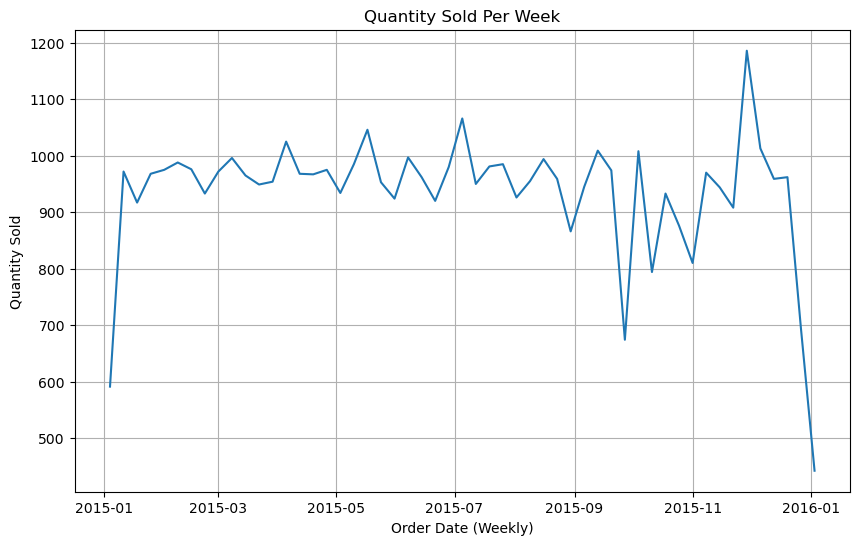

In [297]:
# Group by order date, resample weekly, and sum the quantity
pizza_sale['order_date'] = pd.to_datetime(pizza_sale['order_date'])  
weekly_sales = pizza_sale.resample('W', on='order_date')['quantity'].sum()  

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.xlabel('Order Date (Weekly)')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Per Week')
plt.grid(True)
plt.show()


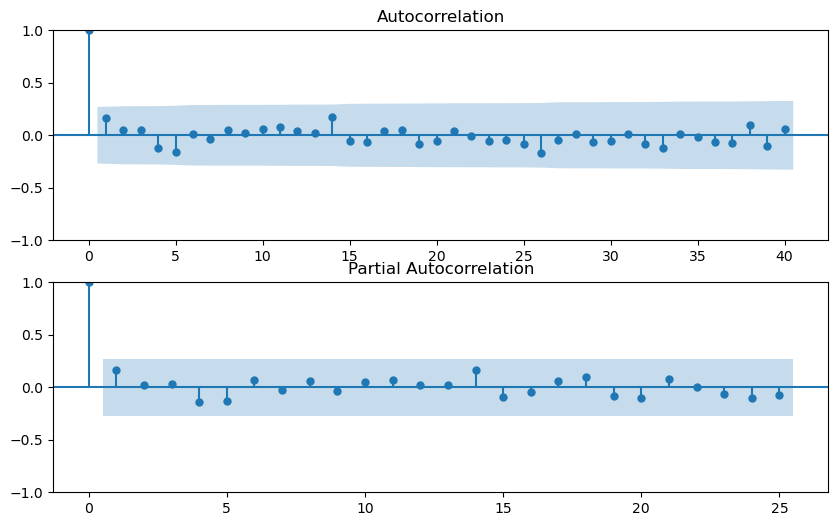

In [298]:
#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(weekly_sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(weekly_sales, lags=25, ax=ax2)


In [299]:
#p=1, q=1, d=0

#check stationary

from statsmodels.tsa.stattools import adfuller

# H0: it is not stationary
# H1: it is stationary

def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [300]:
adf_test(weekly_sales)

ADF Statistic: -4.771161
p-value: 0.000062
# Lags used: 0
No of observations used: 52
we reject the null hypothesis, The series is stationary


In [301]:
#Model Training

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

pizza = pizza_sale.groupby(['order_date'])['quantity'].sum()


In [302]:
pizza.head()

order_date
2015-01-01    162
2015-01-02    165
2015-01-03    158
2015-01-04    106
2015-01-05    125
Name: quantity, dtype: int64

In [303]:
pizza.index = pizza.index.to_period('W')

In [304]:
# split train and test
train_size = int(len(pizza) * 0.8)
train, test = pizza[:train_size], pizza[train_size:]


In [305]:
arima_model = ARIMA(train, order=(1, 0, 1))  # p=1, d=0, q=1
arima_fit = arima_model.fit()

In [306]:
# forecast
ari_forecast = arima_fit.get_forecast(steps=len(test))
ari_fore_values = ari_forecast.predicted_mean

In [307]:
ari_predict = arima_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

In [308]:
ari_predict.index = test.index

In [309]:
# concat test and ari_predict without changing the index of test, test is a pandas series

concatenated_series = pd.concat([test, ari_predict], axis=1)
concatenated_series.columns = ['Actual', 'Predicted']
concatenated_series

,Actual,Predicted
order_date,,
2015-10-12/2015-10-18,105,130.935009
2015-10-19/2015-10-25,154,131.855049
2015-10-19/2015-10-25,149,132.664308
2015-10-19/2015-10-25,145,133.376126
2015-10-19/2015-10-25,154,134.002234
...,...,...
2015-12-21/2015-12-27,89,138.574574
2015-12-28/2016-01-03,102,138.574744
2015-12-28/2016-01-03,80,138.574893


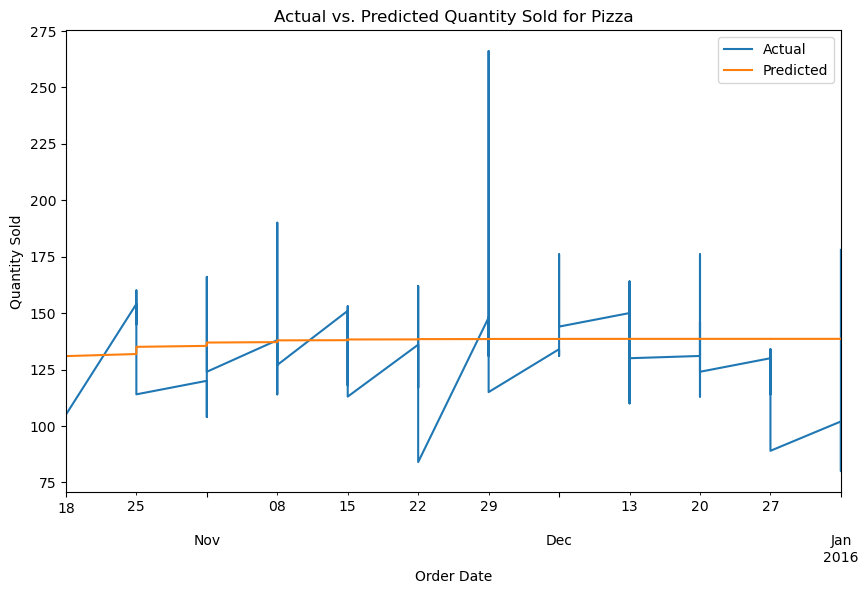

In [310]:
concatenated_series.plot(figsize=(10, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for Pizza')
plt.show()

In [311]:
# Evaluate the model
mape = mean_absolute_percentage_error(test, ari_fore_values)

print(f'ARIMA MAPE: {mape}')


ARIMA MAPE: 0.16541963778893568


In [312]:
# fit SARIMA model
sari_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sari_result = sari_model.fit()

In [313]:
# sarima forecast
sari_forecast = sari_result.get_forecast(steps=len(test))
sari_fore_values = sari_forecast.predicted_mean


In [314]:
# Evaluate Sarima
mape = mean_absolute_percentage_error(test, sari_fore_values)

print(f'SARIMAX MAPE: {mape}')

SARIMAX MAPE: 0.1738790582784574


In [315]:
sari_predict = sari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

In [316]:
sari_predict.index = test.index

In [317]:
concatenated_sarima = pd.concat([test, sari_predict] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima

,Actual,Predicted
order_date,,
2015-10-12/2015-10-18,105,136.485636
2015-10-19/2015-10-25,154,136.973669
2015-10-19/2015-10-25,149,161.125200
2015-10-19/2015-10-25,145,144.213406
2015-10-19/2015-10-25,154,133.114692
...,...,...
2015-12-21/2015-12-27,89,122.031901
2015-12-28/2016-01-03,102,136.497715
2015-12-28/2016-01-03,80,137.682305


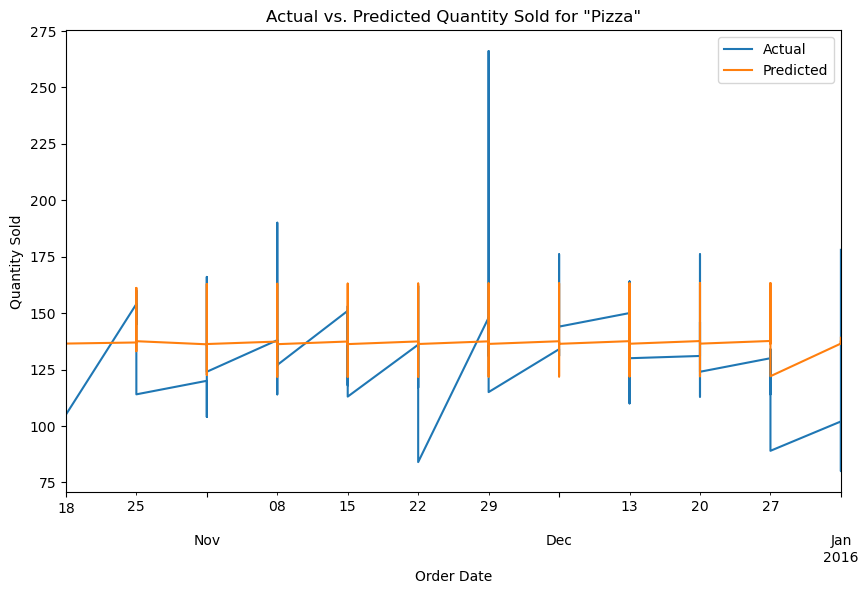

In [318]:
concatenated_sarima.plot(figsize=(10, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "Pizza"')
plt.show()
     

In [319]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [320]:
from prophet import Prophet

In [321]:
 pizza = pizza_sale.groupby(['order_date'])['quantity'].sum()

In [322]:
pizza_df = pizza.reset_index()

In [323]:
pizza_df = pizza_df.rename(columns={'order_date': 'ds', 'quantity': 'y'})

In [324]:
# split train and test
train_size = int(len(pizza_df) * 0.8)
pr_train, pr_test = pizza_df[:train_size], pizza_df[train_size:]

In [325]:
# fit model prophet
pr_model = Prophet()
pr_model.fit(pr_train)

08:27:50 - cmdstanpy - INFO - Chain [1] start processing
08:27:50 - cmdstanpy - INFO - Chain [1] done processing


In [326]:
# forcast for one week
pr_future = pr_model.make_future_dataframe(periods=10, freq='W')
pr_forecast = pr_model.predict(pr_future)

In [327]:
# extract forecast values
pr_forecast_values = pr_forecast['yhat'][-len(pr_test):].values

In [328]:
# Evaluate the model
mape = mean_absolute_percentage_error(pr_test['y'], pr_forecast_values)

print(f'prophet MAPE: {mape}')

prophet MAPE: 0.18675937858868638


In [329]:
concat_prophet = pd.concat([pr_test, pr_forecast[['yhat']].iloc[-len(pr_test):]], axis=1)
concat_prophet.columns = ['date','Actual', 'Predicted']
concat_prophet.set_index('date', inplace=True)
concat_prophet

,Actual,Predicted
date,,
2015-10-18,105.0,116.842075
2015-10-20,154.0,116.874002
2015-10-21,149.0,116.905929
2015-10-22,145.0,116.937856
2015-10-23,154.0,116.969783
...,...,...
NaT,NaN,135.978868
NaT,NaN,135.662046
NaT,NaN,142.566983


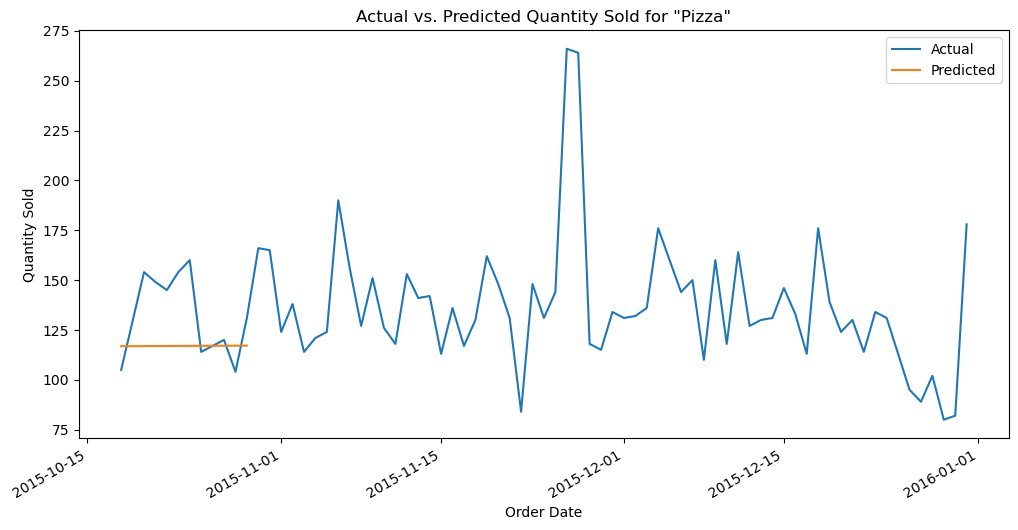

In [330]:
# visualize forecast
concat_prophet.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "Pizza"')
plt.show()

In [331]:
pizza_sale = pizza_sale[['order_date', 'pizza_name', 'quantity']]

In [332]:
#ingredient calculation

sales_summary = pizza_sale.groupby(['order_date', 'pizza_name']).sum().reset_index()

In [333]:
sales_summary.head()

,order_date,pizza_name,quantity
0,2015-01-01,The Barbecue Chicken Pizza,11
1,2015-01-01,The Big Meat Pizza,5
2,2015-01-01,The Calabrese Pizza,1
3,2015-01-01,The California Chicken Pizza,4
4,2015-01-01,The Chicken Alfredo Pizza,2


In [334]:
# reshape data for time series modeling
sales_pivot = sales_summary.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)
     

In [335]:
arima_models = {}

for pizza_name in sales_pivot.columns:
  try:
    model = ARIMA(sales_pivot[pizza_name], order=(1, 0, 1))
    model_fit = model.fit()
    arima_models[pizza_name] = model_fit
  except:
    print(f'ARIMA model for {pizza_name} failed to fit')

In [336]:
# Generate predictions for one week
prediction_days = 7
predictions_arima = {}

for pizza_name, model in arima_models.items():
  predictions_arima[pizza_name] = model.predict(start=len(sales_pivot), end=len(sales_pivot) + prediction_days - 1)
     

In [337]:
predictions_df = pd.DataFrame(predictions_arima)

In [338]:
predictions_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='W')

In [339]:
pizza_ingredients

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0
...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0


In [340]:
# reshape data for time series modeling
sales_pivot = sales_summary.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)

In [341]:
arima_models = {}

for pizza_name in sales_pivot.columns:
  try:
    model = ARIMA(sales_pivot[pizza_name], order=(1, 1, 0))
    model_fit = model.fit()
    arima_models[pizza_name] = model_fit
  except:
    print(f'ARIMA model for {pizza_name} failed to fit')

In [342]:
# Generate predictions for one week
prediction_days = 7
predictions_arima = {}

for pizza_name, model in arima_models.items():
  predictions_arima[pizza_name] = model.predict(start=len(sales_pivot), end=len(sales_pivot) + prediction_days - 1)

In [343]:
predictions_df = pd.DataFrame(predictions_arima)

In [344]:

predictions_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='W')

In [345]:
pizza_ingredients = pizza_ingredients[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]

In [346]:
# change column name to items_qty
pizza_ingredients.rename(columns={'Items_Qty_In_Grams': 'items_qty'}, inplace=True)

In [347]:

predictions_df
     

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-03,7.940297,4.420315,0.868596,1.368239,7.0,2.529125,2.139860,6.884102,3.033661,6.965904,...,3.595451,2.583928,2.064211,5.918578,5.804710,3.537620,2.0,3.169020,3.0,7.773728
2016-01-10,9.000891,5.252117,1.508634,2.255787,7.0,3.250283,3.004890,8.502239,4.000283,8.000291,...,4.253037,3.751409,2.502062,5.496685,7.263264,4.250472,2.0,4.007142,3.0,8.764985
2016-01-17,8.454764,4.814122,1.146563,1.773032,7.0,2.896705,2.602621,7.661914,3.525106,7.474280,...,3.945166,3.187265,2.297193,5.690456,6.597478,3.902985,2.0,3.623496,3.0,8.323624
2016-01-24,8.735979,5.044753,1.351387,2.035612,7.0,3.070061,2.789690,8.098308,3.758696,7.741769,...,4.089306,3.459867,2.393050,5.601459,6.901389,4.072371,2.0,3.799108,3.0,8.520142
2016-01-31,8.591174,4.923311,1.235518,1.892789,7.0,2.985066,2.702696,7.871682,3.643867,7.605745,...,4.021822,3.328142,2.348199,5.642335,6.762663,3.989802,2.0,3.718722,3.0,8.432641
2016-02-07,8.665738,4.987258,1.301065,1.970474,7.0,3.026739,2.743152,7.989373,3.700315,7.674916,...,4.053417,3.391794,2.369185,5.623561,6.825988,4.030051,2.0,3.755518,3.0,8.471601
2016-02-14,8.627343,4.953586,1.263985,1.928219,7.0,3.006307,2.724338,7.928254,3.672566,7.639741,...,4.038625,3.361036,2.359366,5.632183,6.797082,4.010431,2.0,3.738675,3.0,8.454254


In [348]:
pizza_ingredients.head(10)

,pizza_name,pizza_ingredients,items_qty
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0
5,The Barbecue Chicken Pizza,Barbecue Sauce,15.0
6,The Barbecue Chicken Pizza,Barbecued Chicken,30.0
7,The Barbecue Chicken Pizza,Red Peppers,10.0
8,The Barbecue Chicken Pizza,Green Peppers,15.0
9,The Barbecue Chicken Pizza,Tomatoes,20.0


In [350]:
# Create a dictionary to store the ingredient quantities
ingredient_quantities = {}

# Iterate through each pizza in the predictions DataFrame
for pizza_name in predictions_df.columns:
    # Get the predicted quantity for the pizza (sum of all predicted quantities for the pizza)
    predicted_quantity = predictions_df[pizza_name].sum()  # Assuming each column is a different pizza

    # Get the ingredients for the pizza (filter pizza_ingredients for this pizza_name)
    pizza_ingredients_res = pizza_ingredients[pizza_ingredients['pizza_name'] == pizza_name]

    # If no ingredients found for this pizza, continue to the next pizza
    if pizza_ingredients_res.empty:
        continue

    # Iterate through each ingredient for the pizza
    for index, row in pizza_ingredients_res.iterrows():
        ingredient = row['pizza_ingredients']
        ingredient_qty = row['items_qty']

        # Calculate the required quantity of the ingredient
        required_quantity = predicted_quantity * ingredient_qty

        # Add the required quantity to the dictionary
        if ingredient not in ingredient_quantities:
            ingredient_quantities[ingredient] = 0

        ingredient_quantities[ingredient] += required_quantity

# Print the ingredient quantities (output)
for ingredient, quantity in ingredient_quantities.items():
    print(f"{ingredient}: {quantity:.2f} grams")


Barbecued Chicken: 5401.46 grams
Red Peppers: 11343.01 grams
Green Peppers: 8028.58 grams
Tomatoes: 34975.08 grams
Red Onions: 54801.32 grams
Barbecue Sauce: 1800.49 grams
Bacon: 19992.00 grams
Pepperoni: 24182.89 grams
Italian Sausage: 343.95 grams
Chorizo Sausage: 1719.77 grams
Brie Carre Cheese: 260.27 grams
Prosciutto: 260.27 grams
Caramelized Onions: 260.27 grams
Pears: 86.76 grams
Thyme: 43.38 grams
Garlic: 17934.21 grams
?duja Salami: 1586.90 grams
Pancetta: 2380.35 grams
Friggitello Peppers: 396.72 grams
Chicken: 44723.04 grams
Artichokes: 8188.55 grams
Spinach: 21042.62 grams
Jalapeno Peppers: 3769.65 grams
Fontina Cheese: 3920.00 grams
Gouda Cheese: 2940.00 grams
Mushrooms: 26136.37 grams
Asiago Cheese: 4168.32 grams
Alfredo Sauce: 934.39 grams
Pesto Sauce: 3898.15 grams
Mozzarella Cheese: 10227.70 grams
Provolone Cheese: 760.03 grams
Smoked Gouda Cheese: 760.03 grams
Romano Cheese: 760.03 grams
Blue Cheese: 760.03 grams
Ricotta Cheese: 3982.70 grams
Gorgonzola Piccante Chees

In [351]:
# Create a DataFrame from the ingredient quantities
ingredient_requirements_df = pd.DataFrame.from_dict(ingredient_quantities, orient='index', columns=['required_quantity'])

In [352]:
# Print the ingredient requirements
ingredient_requirements_df

,required_quantity
Barbecued Chicken,5401.456843
Red Peppers,11343.011620
Green Peppers,8028.578717
Tomatoes,34975.079263
Red Onions,54801.315429
...,...
Luganega Sausage,2767.612912
Onions,1383.806456
Soppressata Salami,4899.979679
Peperoncini verdi,1408.577238
